# Importing libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

torch.manual_seed(42)
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Our implementation of Compact Transformer Model

In [2]:
# MultiHeadAttention Module
class MSA(nn.Module):
    def __init__(self, embedding_dim: int=192, num_heads: int=3, dropout: float=0):
        super().__init__()
        # layer normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # multiheadattention layer
        self.msa_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=dropout,
                                                   batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        # query, key, value are formed from the same x
        x, _ = self.msa_attention(query=x,
                                    key=x,
                                    value=x,
                                    need_weights=False)
        return x
    
# MLP layer   
class MLP(nn.Module):
    def __init__(self, 
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 dropout: float=0.1):
        super().__init__()
        # layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # two linear layers separated by GeLU activation
        self.mlp = nn.Sequential(
                nn.Linear(in_features=embedding_dim,
                        out_features=mlp_size), # from input_dim to mlp_size
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=mlp_size, # from mlp_size to input_dim
                        out_features=embedding_dim),
                nn.Dropout(p=dropout))
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x
        
# Transformer encoder block
class EncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=192,
                 num_heads: int=3,
                 mlp_size: int=768,
                 mlp_dropout: float=0.1,
                 msa_dropout: float=0.0):
        super().__init__()
        # each block (layer) consists of MSA and MLP
        self.msa = MSA(embedding_dim=embedding_dim,
                       num_heads=num_heads,
                       dropout=msa_dropout)
        
        self.mlp = MLP(embedding_dim=embedding_dim,
                       mlp_size=mlp_size,
                       dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa(x) + x # skip connection #1
        x = self.mlp(x) + x # skip connection #2
        
        return x


# taken from CVT-CCT paper
class Tokenizer(nn.Module):
    def __init__(self,
                 kernel_size: int=7, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding: int=1,
                 conv_layers: int=2, input_channels: int=3, 
                 output_channels: int=64, in_planes: int=64):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, in_planes, 
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)
        
        self.max_pool = nn.MaxPool2d(kernel_size=pooling_kernel_size,
                                     stride=pooling_stride,
                                     padding=pooling_padding)
        
        self.conv2 = nn.Conv2d(in_planes, in_planes+in_planes,       # TODO change
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)
        
        self.conv3 = nn.Conv2d(in_planes+in_planes, output_channels,
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.flatten(x)
        
        return x.permute(0, 2, 1)


class CvT(nn.Module):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__()
        
        self.tokenizer = Tokenizer(kernel_size=kernel_size, stride=stride, 
                                   padding=padding, pooling_kernel_size=pooling_kernel_size, 
                                   pooling_stride=pooling_stride, pooling_padding=pooling_padding, 
                                   conv_layers=conv_layers, input_channels=in_channels, 
                                   output_channels=embedding_dim, in_planes=in_planes)
        
        self.attention_pool = nn.Linear(embedding_dim, 1)
        
        self.emb_dropout = nn.Dropout(p=emb_dropout)
        
        self.encoder = nn.Sequential(*[
            EncoderBlock(embedding_dim=embedding_dim,
                         num_heads=num_heads,
                         mlp_size=mlp_size,
                         mlp_dropout=mlp_dropout,
                         msa_dropout=msa_dropout)
            for _ in range(layers)
        ])
        
        self.norm = nn.LayerNorm(embedding_dim)
        
        self.head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.tokenizer(x)
        x = self.emb_dropout(x)
        x = self.encoder(x)
        x = self.norm(x)
        x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)
        x = self.head(x)
        
        return x
    
class CvT_3(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=3, embedding_dim: int=192, mlp_size: int=384,
                 num_heads: int=3, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_7(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_14(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=14, embedding_dim: int=384, mlp_size: int=1152,
                 num_heads: int=6, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)

# Setting up config Parameters

In [3]:
config = {
    'ROOT_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
    'TEST_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    'MODELS_DIR': '/kaggle/working/',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 100,
    'PATIENCE': 7,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 5e-3,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 4,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

# Utility Functions

In [4]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels


class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [6]:
def adjust_learning_rate(optimizer, epoch, warmup=False, warmup_ep=0, enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [8]:
def save_graphs(train, test, type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Test {type}")
    plt.plot(test,label="valid")
    plt.plot(train,label="train")
    plt.xlabel("Epoch")
    plt.ylabel(f"{type}")
    plt.legend()
    plt.savefig(f'{type}.png')

# Training Functions

In [9]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [11]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

# Model, Optimizer, Criterion

In [12]:
model = CvT_7()
model = model.to(config['DEVICE'])
model_name = "cvt_7"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

In [13]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
CvT_7 (CvT_7)                                           [32, 3, 224, 224]    [32, 10]             --                   True
├─Tokenizer (tokenizer)                                 [32, 3, 224, 224]    [32, 49, 256]        --                   True
│    └─Conv2d (conv1)                                   [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─MaxPool2d (max_pool)                             [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Conv2d (conv2)                                   [32, 64, 56, 56]     [32, 128, 28, 28]    401,408              True
│    └─MaxPool2d (max_pool)                             [32, 128, 28, 28]    [32, 128, 14, 14]    --                   --
│    └─Conv2d (conv3)                                   [32, 128, 14, 14]    [32, 256, 7, 7]      1,605,632            True
│    └─

# Training

Training: 100%|██████████| 281/281 [01:30<00:00,  3.09it/s]


Epoch 1 | Train Loss: 2.280156894086519 | Accuracy: 0.13846925692625006 | Precision: 0.1357105211615264 | Recall: 0.13846925692625006 | F1: 0.12722056169867726


Validating: 100%|██████████| 71/71 [00:15<00:00,  4.69it/s]


	Validation Loss: 1.913266101353605 | Accuracy: 0.2985507246376812 | Precision: 0.37127419144019475 | Recall: 0.2985507246376812 | F1: 0.24656815690231118
Saving best model at epoch 1...


Training: 100%|██████████| 281/281 [01:19<00:00,  3.55it/s]


Epoch 2 | Train Loss: 1.5256914373394432 | Accuracy: 0.4527008194436702 | Precision: 0.43876852165775715 | Recall: 0.4527008194436702 | F1: 0.4394339712349161


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.37it/s]


	Validation Loss: 0.9422000218445147 | Accuracy: 0.6900780379041248 | Precision: 0.6918069257372806 | Recall: 0.6900780379041248 | F1: 0.6704954171361073
Saving best model at epoch 2...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.48it/s]


Epoch 3 | Train Loss: 0.8394214081382412 | Accuracy: 0.7122470594793466 | Precision: 0.704408829173639 | Recall: 0.7122470594793466 | F1: 0.7052663610137875


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.49it/s]


	Validation Loss: 0.7038029507851936 | Accuracy: 0.7612040133779264 | Precision: 0.7956205077457789 | Recall: 0.7612040133779264 | F1: 0.7647464878126095
Saving best model at epoch 3...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.44it/s]


Epoch 4 | Train Loss: 0.4957464860745596 | Accuracy: 0.8374491331735325 | Precision: 0.8349102250743147 | Recall: 0.8374491331735325 | F1: 0.835287447345789


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.47it/s]


	Validation Loss: 0.3196585409238305 | Accuracy: 0.8987736900780379 | Precision: 0.9068279318635316 | Recall: 0.8987736900780379 | F1: 0.8950035254422086
Saving best model at epoch 4...


Training: 100%|██████████| 281/281 [01:17<00:00,  3.62it/s]


Epoch 5 | Train Loss: 0.3361314180376691 | Accuracy: 0.8920787111879146 | Precision: 0.8909530187582368 | Recall: 0.8920787111879146 | F1: 0.8911976353482159


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.41it/s]


	Validation Loss: 0.2442096288145428 | Accuracy: 0.9219620958751393 | Precision: 0.9259734281253336 | Recall: 0.9219620958751393 | F1: 0.9209090692244343
Saving best model at epoch 5...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.44it/s]


Epoch 6 | Train Loss: 0.24590031566675022 | Accuracy: 0.9245219911923741 | Precision: 0.9241126633879841 | Recall: 0.9245219911923741 | F1: 0.9241959250257472


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.42it/s]


	Validation Loss: 0.19529153186250742 | Accuracy: 0.928428093645485 | Precision: 0.9314110824338785 | Recall: 0.928428093645485 | F1: 0.9273743033967208
Saving best model at epoch 6...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.49it/s]


Epoch 7 | Train Loss: 0.20131859132933871 | Accuracy: 0.9367300295445677 | Precision: 0.9367212055347472 | Recall: 0.9367300295445677 | F1: 0.9366352151979779


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.14it/s]


	Validation Loss: 0.14921937085373302 | Accuracy: 0.9542920847268673 | Precision: 0.9559234700696406 | Recall: 0.9542920847268673 | F1: 0.9546345966054751
Saving best model at epoch 7...


Training: 100%|██████████| 281/281 [01:19<00:00,  3.55it/s]


Epoch 8 | Train Loss: 0.16302724093782095 | Accuracy: 0.9489380678967613 | Precision: 0.9489304293091221 | Recall: 0.9489380678967613 | F1: 0.948881877596736


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.20it/s]


	Validation Loss: 0.11855060834122795 | Accuracy: 0.9661092530657748 | Precision: 0.9666500062801711 | Recall: 0.9661092530657748 | F1: 0.9661544045868699
Saving best model at epoch 8...


Training: 100%|██████████| 281/281 [01:19<00:00,  3.51it/s]


Epoch 9 | Train Loss: 0.1389758034784917 | Accuracy: 0.9589163275544902 | Precision: 0.9588359048582312 | Recall: 0.9589163275544902 | F1: 0.9588541185194305


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.30it/s]


	Validation Loss: 0.10420624940643008 | Accuracy: 0.9678929765886287 | Precision: 0.9687130102748063 | Recall: 0.9678929765886287 | F1: 0.9677046507204244
Saving best model at epoch 9...


Training: 100%|██████████| 281/281 [01:18<00:00,  3.58it/s]


Epoch 10 | Train Loss: 0.12266459874808788 | Accuracy: 0.962985673671888 | Precision: 0.9629802867272635 | Recall: 0.962985673671888 | F1: 0.9629709868699968


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.34it/s]


	Validation Loss: 0.09902894207027177 | Accuracy: 0.968561872909699 | Precision: 0.9690923488269813 | Recall: 0.968561872909699 | F1: 0.9683713637126484
Saving best model at epoch 10...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.43it/s]


Epoch 11 | Train Loss: 0.12415575710029153 | Accuracy: 0.9608673839121468 | Precision: 0.9607973759753018 | Recall: 0.9608673839121468 | F1: 0.9608138539036902


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.47it/s]


	Validation Loss: 0.07785341163283922 | Accuracy: 0.9788182831661093 | Precision: 0.9791253976593736 | Recall: 0.9788182831661093 | F1: 0.9788849052815125
Saving best model at epoch 11...


Training: 100%|██████████| 281/281 [01:18<00:00,  3.57it/s]


Epoch 12 | Train Loss: 0.09723326027910374 | Accuracy: 0.9711801103740454 | Precision: 0.9711858955806667 | Recall: 0.9711801103740454 | F1: 0.9711730630535524


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.53it/s]


	Validation Loss: 0.08323886871180484 | Accuracy: 0.9761426978818283 | Precision: 0.9767238340848319 | Recall: 0.9761426978818283 | F1: 0.9761687563911665


Training: 100%|██████████| 281/281 [01:18<00:00,  3.59it/s]


Epoch 13 | Train Loss: 0.09022096032442466 | Accuracy: 0.9710128769719605 | Precision: 0.9709870563393175 | Recall: 0.9710128769719605 | F1: 0.97099347751788


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.53it/s]


	Validation Loss: 0.08217018324566978 | Accuracy: 0.9761426978818283 | Precision: 0.9763344996101444 | Recall: 0.9761426978818283 | F1: 0.9761059484877602


Training: 100%|██████████| 281/281 [01:17<00:00,  3.60it/s]


Epoch 14 | Train Loss: 0.08348568131504215 | Accuracy: 0.9732984001337868 | Precision: 0.9733243851826491 | Recall: 0.9732984001337868 | F1: 0.9733031186927958


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.31it/s]


	Validation Loss: 0.06404006922237156 | Accuracy: 0.9814938684503902 | Precision: 0.9815579816332947 | Recall: 0.9814938684503902 | F1: 0.9815020288702458
Saving best model at epoch 14...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.46it/s]


Epoch 15 | Train Loss: 0.07956255314162405 | Accuracy: 0.9751937120240816 | Precision: 0.9751874058119389 | Recall: 0.9751937120240816 | F1: 0.97518462961352


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.34it/s]


	Validation Loss: 0.057310477272987784 | Accuracy: 0.9841694537346711 | Precision: 0.9843294442520502 | Recall: 0.9841694537346711 | F1: 0.984119650130738
Saving best model at epoch 15...


Training: 100%|██████████| 281/281 [01:18<00:00,  3.56it/s]


Epoch 16 | Train Loss: 0.07550360022768962 | Accuracy: 0.9771447683817381 | Precision: 0.9771350732044982 | Recall: 0.9771447683817381 | F1: 0.9771299258637264


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.55it/s]


	Validation Loss: 0.05735240733696961 | Accuracy: 0.9810479375696767 | Precision: 0.9811368445799221 | Recall: 0.9810479375696767 | F1: 0.9810712620301677


Training: 100%|██████████| 281/281 [01:19<00:00,  3.54it/s]


Epoch 17 | Train Loss: 0.06598016066025955 | Accuracy: 0.9814370923685825 | Precision: 0.9814342919092108 | Recall: 0.9814370923685825 | F1: 0.9814330444752691


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.59it/s]


	Validation Loss: 0.06205814697740363 | Accuracy: 0.9817168338907469 | Precision: 0.9819704736499326 | Recall: 0.9817168338907469 | F1: 0.9817395808497682


Training: 100%|██████████| 281/281 [01:22<00:00,  3.42it/s]


Epoch 18 | Train Loss: 0.05471619743409689 | Accuracy: 0.9839455933998551 | Precision: 0.9839431086621193 | Recall: 0.9839455933998551 | F1: 0.9839428100689759


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.41it/s]


	Validation Loss: 0.08319492916196165 | Accuracy: 0.9739130434782609 | Precision: 0.9741361530961519 | Recall: 0.9739130434782609 | F1: 0.9737994373511709


Training: 100%|██████████| 281/281 [01:18<00:00,  3.58it/s]


Epoch 19 | Train Loss: 0.060137646387122386 | Accuracy: 0.9806009253581582 | Precision: 0.9805914474568719 | Recall: 0.9806009253581582 | F1: 0.9805931965750121


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


	Validation Loss: 0.053460333745559335 | Accuracy: 0.9835005574136009 | Precision: 0.9837574701923051 | Recall: 0.9835005574136009 | F1: 0.9835030604175955
Saving best model at epoch 19...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.47it/s]


Epoch 20 | Train Loss: 0.05689116412760471 | Accuracy: 0.9824962372484531 | Precision: 0.9824971488254383 | Recall: 0.9824962372484531 | F1: 0.9824946605787039


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.36it/s]


	Validation Loss: 0.056995901003689835 | Accuracy: 0.9828316610925306 | Precision: 0.9832887748783509 | Recall: 0.9828316610925306 | F1: 0.9828456940556252


Training: 100%|██████████| 281/281 [01:18<00:00,  3.57it/s]


Epoch 21 | Train Loss: 0.05653644709605923 | Accuracy: 0.9816043257706673 | Precision: 0.9815963105389195 | Recall: 0.9816043257706673 | F1: 0.9815971483564488


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.40it/s]


	Validation Loss: 0.05365927787628812 | Accuracy: 0.986845039018952 | Precision: 0.9868845678727733 | Recall: 0.986845039018952 | F1: 0.9868384619807806


Training: 100%|██████████| 281/281 [01:18<00:00,  3.56it/s]


Epoch 22 | Train Loss: 0.047111650076247354 | Accuracy: 0.9845030380734712 | Precision: 0.9845102259737555 | Recall: 0.9845030380734712 | F1: 0.9845053826646976


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.38it/s]


	Validation Loss: 0.04643806822771784 | Accuracy: 0.9843924191750278 | Precision: 0.9846324321496803 | Recall: 0.9843924191750278 | F1: 0.9844209895665063
Saving best model at epoch 22...


Training: 100%|██████████| 281/281 [01:21<00:00,  3.43it/s]


Epoch 23 | Train Loss: 0.0513168180749165 | Accuracy: 0.9837226155304086 | Precision: 0.983742248883526 | Recall: 0.9837226155304086 | F1: 0.983728657466653


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.51it/s]


	Validation Loss: 0.04957444891071235 | Accuracy: 0.9870680044593088 | Precision: 0.9871136250800662 | Recall: 0.9870680044593088 | F1: 0.9870238550179028


Training: 100%|██████████| 281/281 [01:19<00:00,  3.53it/s]


Epoch 24 | Train Loss: 0.047230078816393996 | Accuracy: 0.9847260159429176 | Precision: 0.9847197182996871 | Recall: 0.9847260159429176 | F1: 0.9847218511632448


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.52it/s]


	Validation Loss: 0.052482774841900864 | Accuracy: 0.9841694537346711 | Precision: 0.9845839168356053 | Recall: 0.9841694537346711 | F1: 0.9841999874024702


Training: 100%|██████████| 281/281 [01:18<00:00,  3.58it/s]


Epoch 25 | Train Loss: 0.039114775657289234 | Accuracy: 0.9876247282457216 | Precision: 0.9876291377915943 | Recall: 0.9876247282457216 | F1: 0.9876245367747829


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.59it/s]


	Validation Loss: 0.03866315845065606 | Accuracy: 0.988628762541806 | Precision: 0.988728618813501 | Recall: 0.988628762541806 | F1: 0.9886460775240834
Saving best model at epoch 25...


Training: 100%|██████████| 281/281 [01:20<00:00,  3.49it/s]


Epoch 26 | Train Loss: 0.04239707763200738 | Accuracy: 0.9871787725068287 | Precision: 0.9871739221049549 | Recall: 0.9871787725068287 | F1: 0.9871738072761942


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.56it/s]


	Validation Loss: 0.0500435456043293 | Accuracy: 0.9839464882943144 | Precision: 0.9841263886774415 | Recall: 0.9839464882943144 | F1: 0.9839830007011613


Training: 100%|██████████| 281/281 [01:21<00:00,  3.46it/s]


Epoch 27 | Train Loss: 0.03729680457419229 | Accuracy: 0.9886838731255922 | Precision: 0.9886907370078102 | Recall: 0.9886838731255922 | F1: 0.9886857798476556


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.19it/s]


	Validation Loss: 0.051867812167497314 | Accuracy: 0.9828316610925306 | Precision: 0.9829957299747049 | Recall: 0.9828316610925306 | F1: 0.9828023812724879


Training: 100%|██████████| 281/281 [01:20<00:00,  3.48it/s]


Epoch 28 | Train Loss: 0.04309966925654255 | Accuracy: 0.9855064384859803 | Precision: 0.9855214426314629 | Recall: 0.9855064384859803 | F1: 0.9855119721601262


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.25it/s]


	Validation Loss: 0.05545060243621521 | Accuracy: 0.9843924191750278 | Precision: 0.9847085214275336 | Recall: 0.9843924191750278 | F1: 0.9844321180995617


Training: 100%|██████████| 281/281 [01:18<00:00,  3.56it/s]


Epoch 29 | Train Loss: 0.03280093315972207 | Accuracy: 0.9894642956686549 | Precision: 0.9894672443482626 | Recall: 0.9894642956686549 | F1: 0.989463976639892


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.045832710448016324 | Accuracy: 0.988628762541806 | Precision: 0.9887228244400414 | Recall: 0.988628762541806 | F1: 0.9886223196779799


Training: 100%|██████████| 281/281 [01:21<00:00,  3.45it/s]


Epoch 30 | Train Loss: 0.03545037726540238 | Accuracy: 0.9890740843971236 | Precision: 0.9890766235465337 | Recall: 0.9890740843971236 | F1: 0.9890741444262164


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.66it/s]


	Validation Loss: 0.044569366263114175 | Accuracy: 0.987736900780379 | Precision: 0.987897877764212 | Recall: 0.987736900780379 | F1: 0.9877151697626366


Training: 100%|██████████| 281/281 [01:18<00:00,  3.57it/s]


Epoch 31 | Train Loss: 0.036626620643632986 | Accuracy: 0.9881264284519762 | Precision: 0.9881252535837323 | Recall: 0.9881264284519762 | F1: 0.9881254159737491


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.64it/s]


	Validation Loss: 0.04461086211516194 | Accuracy: 0.987736900780379 | Precision: 0.9878356202440688 | Recall: 0.987736900780379 | F1: 0.9877129725450527


Training: 100%|██████████| 281/281 [01:20<00:00,  3.50it/s]


Epoch 32 | Train Loss: 0.031145858586462564 | Accuracy: 0.9904119516138024 | Precision: 0.9904169540956799 | Recall: 0.9904119516138024 | F1: 0.9904123247771226


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.40it/s]


	Validation Loss: 0.04959125941025723 | Accuracy: 0.9850613154960981 | Precision: 0.9852122970485877 | Recall: 0.9850613154960981 | F1: 0.9850020270444172
Early stopping at epoch 32
Training finished!


({'Loss': [2.280156894086519,
   1.5256914373394432,
   0.8394214081382412,
   0.4957464860745596,
   0.3361314180376691,
   0.24590031566675022,
   0.20131859132933871,
   0.16302724093782095,
   0.1389758034784917,
   0.12266459874808788,
   0.12415575710029153,
   0.09723326027910374,
   0.09022096032442466,
   0.08348568131504215,
   0.07956255314162405,
   0.07550360022768962,
   0.06598016066025955,
   0.05471619743409689,
   0.060137646387122386,
   0.05689116412760471,
   0.05653644709605923,
   0.047111650076247354,
   0.0513168180749165,
   0.047230078816393996,
   0.039114775657289234,
   0.04239707763200738,
   0.03729680457419229,
   0.04309966925654255,
   0.03280093315972207,
   0.03545037726540238,
   0.036626620643632986,
   0.031145858586462564],
  'Accuracy': [0.13846925692625006,
   0.4527008194436702,
   0.7122470594793466,
   0.8374491331735325,
   0.8920787111879146,
   0.9245219911923741,
   0.9367300295445677,
   0.9489380678967613,
   0.9589163275544902,
   0.

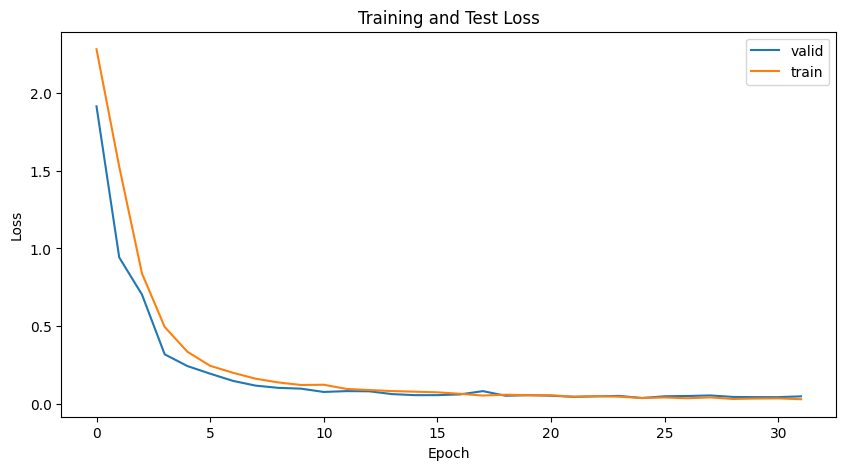

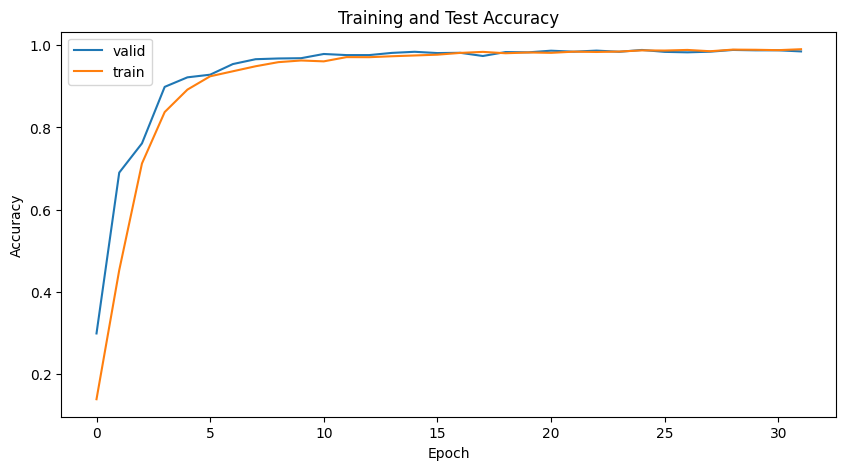

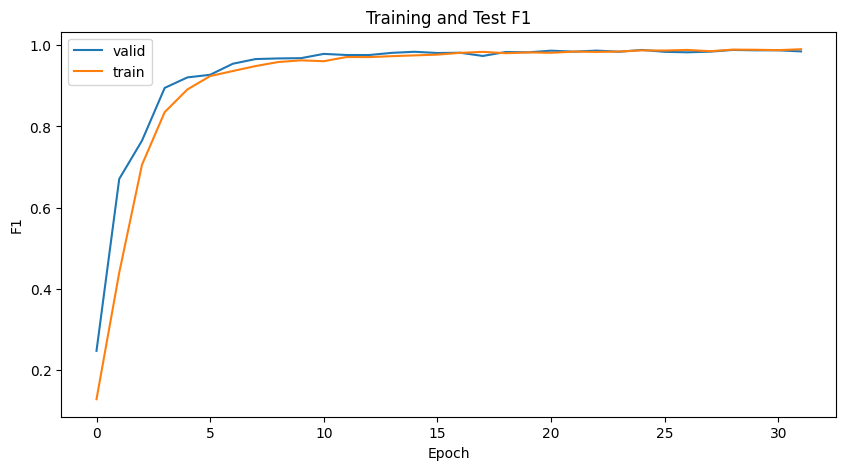

In [14]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [15]:
class InferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [16]:
def inference(test_loader, model, model_name, config):
    if model_name == 'resnet50' or model_name == 'resnet101':
        model.fc = nn.Linear(2048, 10)
    elif model_name == 'cvt_3' or model_name == 'cvt_7' or model_name == 'cvt_14':
        pass
    else:
        raise NotImplementedError('unknown architecture')
    
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [17]:
test_transformations = val_transforms
test_dataset = InferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = inference(test_loader, model, model_name, config)

Inference: 100%|██████████| 1246/1246 [05:31<00:00,  3.76it/s]


In [18]:
df.to_csv(f'submission {model_name}.csv', index=False)